In [1]:
#!pip install opendatasets 
#!pip install pandas
#!pip install timm
#!pip install opencv-python

In [2]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = 1
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4) 
from tqdm import tqdm
from textwrap import wrap
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2

import timm

In [3]:
import opendatasets as od
import pandas
od.download('https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset/code?select=classification')

Skipping, found downloaded files in "./ip02-dataset" (use force=True to force download)


In [4]:
f = open('ip02-dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


In [5]:

def resize_all(src, width=64, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    traindata = dict()
    traindata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    traindata['label'] = []
    traindata['filename'] = []
    traindata['data'] = []   
    testdata = dict()
    testdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    testdata['label'] = []
    testdata['filename'] = []
    testdata['data'] = []   
    valdata = dict()
    valdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    valdata['label'] = []
    valdata['filename'] = []
    valdata['data'] = []   
    dicts = [testdata,traindata,valdata]
    #pklname = f"{pklname}_{width}x{height}px.pkl"
    y = 0
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print(subdir)
        current_path = os.path.join(src, subdir)
        directory = current_path
        for subdir2 in os.listdir(current_path):
            print(current_path)
            current_path = os.path.join(directory, subdir2)
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    dicts[y]['label'].append(subdir2)
                    dicts[y]['filename'].append(file)
                    dicts[y]['data'].append(im)
        y += 1
        #joblib.dump(data, pklname)
    return dicts

In [6]:
data_path = 'ip02-dataset/classification'
stuff = os.listdir(data_path)
print(len(stuff))

3


In [7]:
train_df = pd.read_csv('ip02-dataset/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('ip02-dataset/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('ip02-dataset/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

,image_path,label
0,00002.jpg,0
1,00003.jpg,0
2,00005.jpg,0
3,00006.jpg,0
4,00008.jpg,0


In [8]:
TRAIN_DIR = 'ip02-dataset/classification/train'
TEST_DIR = 'ip02-dataset/classification/test'
VAL_DIR = 'ip02-dataset/classification/val'
LR = 2e-5
BATCH_SIZE = 4
EPOCH = 2
print_every = 100
dtype = torch.float32
device = torch.device('cuda')

In [9]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [10]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(73984, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.relu(self.conv_2(self.relu((self.conv_1(x)))))
        x = flatten(x)
        scores = self.fc1(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

In [11]:
#data_transform = transforms.Compose([transforms.ToTensor(),
                                     #transforms.RandomVerticalFlip(),
                                     #transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     #transforms.RandomHorizontalFlip(),
                                     #transforms.ColorJitter(),
                                     #transforms.Resize((34,34))])


In [12]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224))])

In [13]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [14]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=data_transform)
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=data_transform)
valid_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

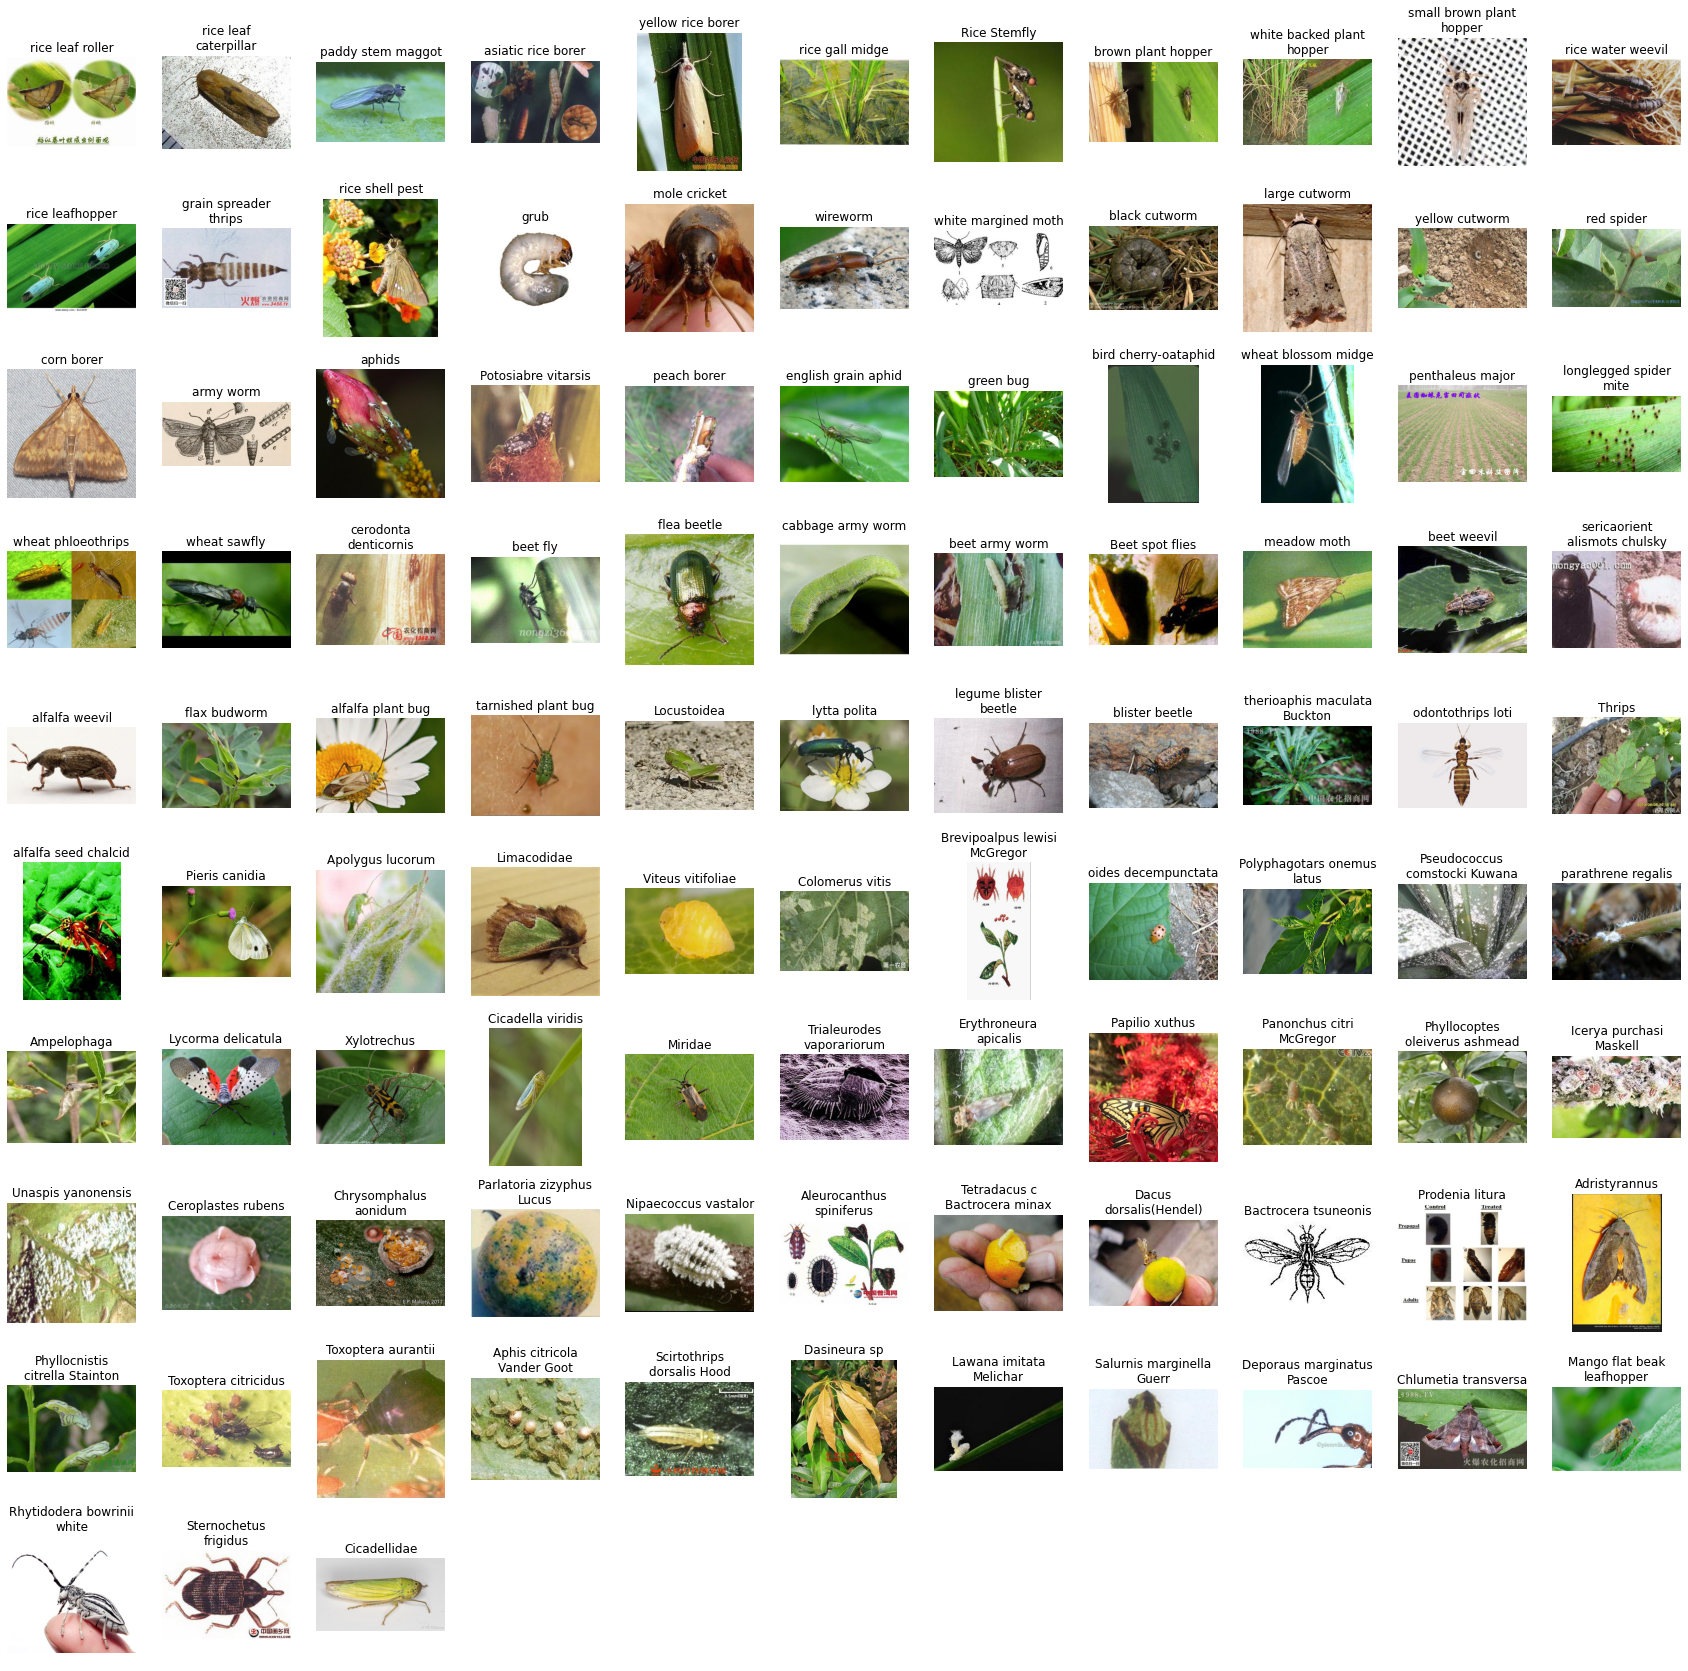

In [15]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [16]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [17]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

In [18]:
#os.environ['WANDB_CONSOLE'] = 'off'
def run():
    model = InsectModel(num_classes=102)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    best_loss = 10**5
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f}')

In [19]:
#run()

In [20]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        acc_list.append(acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [21]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [25]:
iter_list = []
acc_list = []
def train_part34(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            #print(1)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype).float()  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy_part34(valid_loader, model)
                iter_list.append(t)
                print()

In [26]:
#timm.list_models()

In [27]:
channel_1 = 34
channel_2 = 68
model = InsectModel(102)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#print(train_loader)
train_part34(model, optimizer, epochs=1)

Epoch 0, Iteration 0, loss = 4.7138
Got 118 / 7508 correct (1.57)

Epoch 0, Iteration 100, loss = 4.4236
Got 1805 / 7508 correct (24.04)

Epoch 0, Iteration 200, loss = 2.0493
Got 2469 / 7508 correct (32.88)

Epoch 0, Iteration 300, loss = 1.8751
Got 2621 / 7508 correct (34.91)

Epoch 0, Iteration 400, loss = 2.2655
Got 2912 / 7508 correct (38.79)

Epoch 0, Iteration 500, loss = 2.9841
Got 3114 / 7508 correct (41.48)

Epoch 0, Iteration 600, loss = 1.9397
Got 3230 / 7508 correct (43.02)

Epoch 0, Iteration 700, loss = 1.6291
Got 3361 / 7508 correct (44.77)



libpng warning: iCCP: known incorrect sRGB profile


Epoch 0, Iteration 800, loss = 1.5002
Got 3523 / 7508 correct (46.92)

Epoch 0, Iteration 900, loss = 3.1082
Got 3647 / 7508 correct (48.57)

Epoch 0, Iteration 1000, loss = 3.1252
Got 3693 / 7508 correct (49.19)

Epoch 0, Iteration 1100, loss = 1.6038
Got 3726 / 7508 correct (49.63)

Epoch 0, Iteration 1200, loss = 3.5470
Got 3758 / 7508 correct (50.05)

Epoch 0, Iteration 1300, loss = 3.7875
Got 3878 / 7508 correct (51.65)

Epoch 0, Iteration 1400, loss = 2.6462
Got 3979 / 7508 correct (53.00)

Epoch 0, Iteration 1500, loss = 2.3422
Got 4050 / 7508 correct (53.94)

Epoch 0, Iteration 1600, loss = 1.3727
Got 4022 / 7508 correct (53.57)

Epoch 0, Iteration 1700, loss = 1.5760
Got 4019 / 7508 correct (53.53)

Epoch 0, Iteration 1800, loss = 0.7121
Got 4228 / 7508 correct (56.31)

Epoch 0, Iteration 1900, loss = 1.4107
Got 4230 / 7508 correct (56.34)

Epoch 0, Iteration 2000, loss = 3.0160
Got 4297 / 7508 correct (57.23)

Epoch 0, Iteration 2100, loss = 1.4391
Got 4339 / 7508 correct (57

KeyboardInterrupt: 

Text(0.5, 0, 'Iteration')

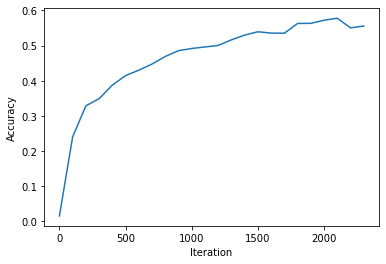

In [28]:
plt.plot(iter_list,acc_list,label = 'Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Iteration")

In [ ]:
model = InsectModel(num_classes=102)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,8))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()